# PiedPiper Dataset - Exploratory Data Analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nehalecky/hello-cloud/blob/master/notebooks/published/05_EDA_piedpiper_data.ipynb)

## Overview

This notebook supports exploratory analysis for PiedPiper billing data, including:

- Data loading and quality assessment
- Schema-level attribute analysis and filtering
- Grain discovery for time series forecasting
- Entity persistence validation
- Time series visualization for stable entities

**Objectives**:
 * Create data model containg high info gain variables to support downstream analysis and modeling
 * Identify the optimal compound key (grain) for the time series
 * Basic understanding of time series distributions.

**Dataset**: PiedPiper production billing data (122 days, 8.3M records)

---

## Assumptions

Cloud billing data represents resource consumption events aggregated by CZ data pipeline. We conceptualize the **event space** as:

- $\mathbf{E}_0$ (full space): All cloud resource consumption across all providers, accounts, and time
- $\mathbf{E}$ (observed): pied Piper sample produced by CZ, where $\mathbf{E} \subseteq \mathbf{E}_0$

**Known sampling biases**:
1. **Provider coverage**: Only resources with cost allocation tags are visible
2. **Temporal granularity**: Daily aggregation (not real-time)
3. **Data quality**: Provider-specific pipeline issues may cause artifactual patterns

**Expected billing event structure**:

A cloud resource cost (CRC) record fundamentally contains:
- $t$ (timestamp): When resource was consumed (daily grain)
- $r$ (resource): Identifier for the billable cloud resource
- $c$ (cost): Dollar amount for the consumption

**Question**: What compound key defines the resource identifier $r$ such that we can track spending over time?

This is the **grain discovery problem** - finding the most granular combination of attributes whose entities persist temporally, enabling forecasting.

---

## Part 1: Data Loading & Schema Analysis

### 1.1 Import Dependencies

In [1]:
# Environment Setup
# Local: Uses installed hellocloud
# Colab: Installs from GitHub
try:
    import hellocloud
except ImportError:
    !pip install -q git+https://github.com/nehalecky/hello-cloud.git
    import hellocloud

In [2]:
# Auto-reload: Picks up library changes without kernel restart
%load_ext autoreload
%autoreload 2

In [3]:
# Data Configuration
# Update this path to point to your PiedPiper dataset (raw parquet file)
from pathlib import Path

# Option 1: Local path (default)
data_path = Path("data/piedpiper.parquet")

# Option 2: Colab - Upload file or mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# data_path = Path("/content/drive/MyDrive/datasets/piedpiper.parquet")

# Option 3: Download from URL (if publicly hosted)
# !wget https://example.com/piedpiper.parquet -O piedpiper.parquet
# data_path = Path("piedpiper.parquet")

In [4]:
from pathlib import Path
from datetime import date, datetime, timedelta
from pyspark.sql import functions as F
from pyspark.sql import Window
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from loguru import logger

# Import hellocloud with namespace access
import hellocloud as hc

# Get Spark session
spark = hc.spark.get_spark_session(app_name="piedpiper-eda")

# Configure visualization style
#hc.utils.setup_seaborn_style(style='whitegrid', palette='husl', context='notebook')

hc.configure_notebook_logging()
logger.info("PiedPiper EDA - Notebook initialized (PySpark + Seaborn)")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/15 12:22:08 WARN Utils: Your hostname, nico-mbp-m4-2.local, resolves to a loopback address: 127.0.0.1; using 192.168.68.50 instead (on interface en0)
25/10/15 12:22:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/15 12:22:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
INFO     | PiedPiper EDA - Notebook initialized (PySpark + Seaborn)


### 1.2 Load Dataset

In [ ]:
# Load Parquet file
DATA_PATH = Path('~/Projects/cloudzero/hello-cloud/data/piedpiper_optimized_daily.parquet').expanduser()
df = spark.read.parquet(str(DATA_PATH))
#df = df.cache()  # Cache for faster repeated access

# Basic shape
total_rows = df.count()
total_cols = len(df.columns)
logger.info(f"Dataset: {total_rows:,} rows × {total_cols} columns")
logger.info(f"Backend: PySpark (distributed analytical engine)")

# Preview
df.limit(5).toPandas()

25/10/15 12:22:17 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/10/15 12:22:23 WARN MemoryStore: Not enough space to cache rdd_6_7 in memory! (computed 224.9 MiB so far)
25/10/15 12:22:23 WARN BlockManager: Persisting block rdd_6_7 to disk instead.
25/10/15 12:22:23 WARN MemoryStore: Not enough space to cache rdd_6_9 in memory! (computed 262.9 MiB so far)
25/10/15 12:22:23 WARN BlockManager: Persisting block rdd_6_9 to disk instead.
25/10/15 12:22:23 WARN MemoryStore: Not enough space to cache rdd_6_0 in memory! (computed 257.4 MiB so far)
25/10/15 12:22:23 WARN BlockManager: Persisting block rdd_6_0 to disk instead.
25/10/15 12:22:24 WARN MemoryStore: Not enough space to cache rdd_6_0 in memory! (computed 257.4 MiB so far)
25/10/15 12:22:25 WARN MemoryStore: Not enough space to cache rdd_6_0 in memory! (computed 257.4 MiB so far)
INFO     | Dataset: 8,336,995

,materialized_discounted_cost,product_family,materialized_public_on_demand_cost,materialized_usage_amount,payer_account_id,_k8s_cbf_cluster_name,cloud_provider,payer_account_name,usage_date,materialized_cost,...,custom_edp_category,usage_type,resource_id,billing_connection_id,billing_period_start_date,materialized_invoiced_amortized_cost,cloud_account_id,_k8s_cbf_pod_id,committed_use_subscription,aggregated_records
0,0.098948,Usage,0.098948,0.000000,132e70b2-7e1f-45b6-abbc-b47c4665073f,None,MongoDB,NaN,2025-09-01,0.098948,...,NaN,None,czrn:mongodb:atlas_aws_instance_m10:sa_east_1:...,132e70b2-7e1f-45b6-abbc-b47c4665073f,2025-09-01,0.098948,Platform-Engineering|507f1f77bcf86cd799439011,None,None,24
1,0.000543,API Request,0.000600,120.000000,949156204738,None,AWS,NaN,2025-09-01,0.000600,...,NaN,USE1-AWSSecretsManagerAPIRequest,czrn:aws:secretsmanager:us-east-1:061190967865...,100000000000,2025-09-01,0.000543,061190967865,None,None,4
2,0.000005,API Request,0.000006,2.000000,949156204738,None,AWS,NaN,2025-09-01,0.000006,...,NaN,ap-southeast-1-KMS-Requests,czrn:aws:kms:ap-southeast-1:061190967865:key:2...,100000000000,2025-09-01,0.000005,061190967865,None,None,2
3,16.120608,Virtual Machines,16.120608,387.607483,a7c9c923-926d-417a-ad71-11635fb5f8c9,None,Azure,NaN,2025-09-01,16.120608,...,NaN,Ev3/ESv3 Series,czrn:azure:microsoft.compute:westeurope:produc...,a7c9c923-926d-417a-ad71-11635fb5f8c9,2025-09-01,16.120608,Feature-Engineering|sub-01OO0QW24yESpu4Z0yh2n9tS,None,None,24
4,0.000000,Licensing Fee for Container-Optimized OS from ...,NaN,15.140556,01403A-796D57-F2D8D8,gke-cirrus-research-istio,GCP,NaN,2025-09-01,0.000000,...,NaN,None,czrn:gcp:compute-engine:us-central1-b:34076077...,8efe6839-b2ae-47e9-9ec2-307f3f681388,2025-09-01,0.000000,research-339517,4611527842131928259:gke-cirrus-research-istio:...,None,28


---

### 1.3 Temporal Observation Density

In [ ]:
df.limit(1).toPandas().dtypes

25/10/15 12:42:17 WARN MemoryStore: Not enough space to cache rdd_6_0 in memory! (computed 257.4 MiB so far)


materialized_discounted_cost                     float64
product_family                                    object
materialized_public_on_demand_cost               float64
materialized_usage_amount                        float64
payer_account_id                                  object
_k8s_cbf_cluster_name                             object
cloud_provider                                    object
payer_account_name                               float64
usage_date                                datetime64[ns]
materialized_cost                                float64
_k8s_cbf_pod_name                                 object
aws_product_name                                  object
pricing_unit                                      object
line_item_type                                    object
uuid                                              object
transfer_type                                     object
region                                            object
billing_entity                 

In [13]:
df.schema

StructType([StructField('materialized_discounted_cost', DoubleType(), True), StructField('product_family', StringType(), True), StructField('materialized_public_on_demand_cost', DoubleType(), True), StructField('materialized_usage_amount', DoubleType(), True), StructField('payer_account_id', StringType(), True), StructField('_k8s_cbf_cluster_name', StringType(), True), StructField('cloud_provider', StringType(), True), StructField('payer_account_name', IntegerType(), True), StructField('usage_date', TimestampNTZType(), True), StructField('materialized_cost', DoubleType(), True), StructField('_k8s_cbf_pod_name', StringType(), True), StructField('aws_product_name', StringType(), True), StructField('pricing_unit', StringType(), True), StructField('line_item_type', StringType(), True), StructField('uuid', StringType(), True), StructField('transfer_type', StringType(), True), StructField('region', StringType(), True), StructField('billing_entity', StringType(), True), StructField('cloud_acc

In [21]:
# Identify date column and stats
from re import A
from pyspark.sql.types import DateType, TimestampType, TimestampNTZType

date_cols = [
    field.name for field in df.schema.fields
    if isinstance(field.dataType, (DateType, TimestampType, TimestampNTZType))
]
date_cols
# logger.info(f"Date/Datetime columns found: {date_cols}")
# logger.info(f"Renaming {date_cols[0]} → date")
# df = df.withColumnRenamed(date_cols[0], 'date')

# date_stats = df.agg(
#     F.countDistinct('date').alias('unique_date'),
#     F.min('date').alias('min_date'),
#     F.max('date').alias('max_date')
# )
# date_stats.toPandas()

['usage_date', 'billing_period_start_date']

**Noted** Max date spans into the future `2025-12-31`.

Let's inspect the temporal record density and plot.

In [4]:
df.transform(hc.transforms.summary_stats(value_col='cost', group_col='date'))

┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ count_mean  ┃ count_median ┃ count_std    ┃ count_min ┃ count_max ┃ count_q25 ┃ count_q75 ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│ float64     │ float64      │ float64      │ int64     │ int64     │ float64   │ float64   │
├─────────────┼──────────────┼──────────────┼───────────┼───────────┼───────────┼───────────┤
│ 68336.02459 │      29937.5 │ 59768.716511 │     29930 │    169553 │   29936.0 │  156903.0 │
└─────────────┴──────────────┴──────────────┴───────────┴───────────┴───────────┴───────────┘

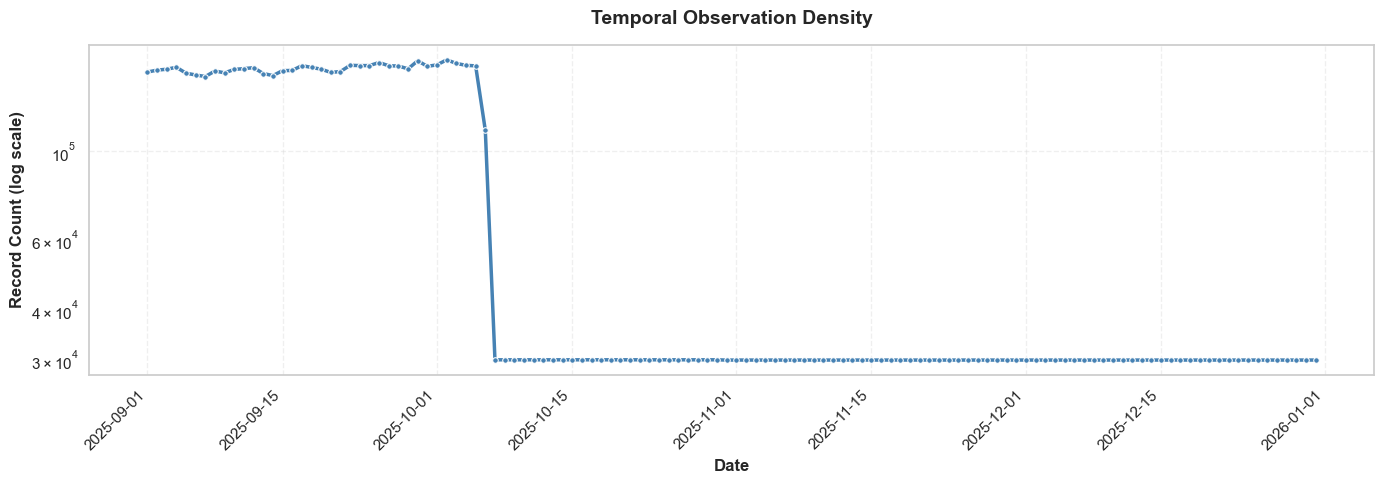

In [5]:
# Plot temporal observation density with seaborn (enhanced with ConciseDateFormatter and shading)
fig = hc.analysis.eda.plot_temporal_density(
    df,
    date_col='date',
    log_scale=True,
    title='Temporal Observation Density'
)
plt.show()

**Observation**: The time series shows a sharp drop at a specific date, with data continuing into the future. Something is off—let's investigate the magnitude of day-over-day changes to identify the anomaly.

In [6]:
# Compute day-over-day percent change using transform pattern
from hellocloud.transforms import pct_change

daily_counts = (
    df.groupBy('date')
    .agg(F.count('*').alias('count'))
    .orderBy('date')
)

daily_with_change = daily_counts.transform(
    pct_change(value_col='count', order_col='date')
)

# Find largest drops (most negative percent changes)
largest_drops = (
    daily_with_change
    .filter(F.col('pct_change').isNotNull())
    .orderBy('pct_change')
    .limit(5)
    .select('date', 'count', 'pct_change')
)

logger.info("Largest day-over-day drops:")
largest_drops.toPandas()

INFO     | Largest day-over-day drops:


┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ date                ┃ count  ┃ count_pct_change ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ timestamp(6)        │ int64  │ float64          │
├─────────────────────┼────────┼──────────────────┤
│ 2025-10-07 00:00:00 │  29980 │        -0.734561 │
│ 2025-10-06 00:00:00 │ 112945 │        -0.310331 │
│ 2025-09-05 00:00:00 │ 156977 │        -0.033684 │
│ 2025-09-13 00:00:00 │ 156681 │        -0.033174 │
│ 2025-09-30 00:00:00 │ 163289 │        -0.031748 │
└─────────────────────┴────────┴──────────────────┘

The data shows a significant drop (>30%) on a specific date. We'll filter to the period before this anomaly for clean analysis.

In [7]:
# Find earliest date with >30% drop (pct_change returns percentage, so -30.0)
cutoff_date_result = (
    daily_with_change
    .filter(F.col('pct_change') < -30.0)
    .orderBy('date')
    .limit(1)
    .select('date')
    .toPandas()
)

CUTOFF_DATE = cutoff_date_result['date'].iloc[0]
logger.info(f"Cutoff date detected: {CUTOFF_DATE}")

# Apply filter to PySpark DataFrame
df = df.filter(F.col('date') < CUTOFF_DATE)

# Compute stats
stats = df.agg(
    F.count('*').alias('rows'),
    F.countDistinct('date').alias('days'),
    F.min('date').alias('start'),
    F.max('date').alias('end')
)
stats.toPandas()

INFO     | Cutoff date detected: 2025-10-06 00:00:00


┏━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ rows    ┃ days  ┃ start               ┃ end                 ┃
┡━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ int64   │ int64 │ timestamp(6)        │ timestamp(6)        │
├─────────┼───────┼─────────────────────┼─────────────────────┤
│ 5648499 │    35 │ 2025-09-01 00:00:00 │ 2025-10-05 00:00:00 │
└─────────┴───────┴─────────────────────┴─────────────────────┘

---

### 1.4 General Attribute Analysis

**Methodology**: We analyze the information density in each attribute using metrics that capture value density, cardinality, and confusion, allowing us to understand the information available within each attribute. We leverage this to find ideal attributes that support our event and time series discrimination efforts.

#### Value Density
The density of non-null values across attributes (completeness indicator). Low values imply high sparsity (many nulls), which are likely not informative for modeling or grain discovery. **Higher is better**.

#### Nonzero Density (Numeric Columns)
The density of non-zero values among numeric attributes. High nonzero density indicates rich variation; low values indicate dominance of zeros (measurement artifacts, optional features, sparse usage). For cost columns, low nonzero density represents frequent periods of no consumption. Non-numeric columns default to 1.0 (treated as "all nonzero" for scoring). **Higher is better**.

#### Cardinality Ratio
The ratio of unique values to total observations (`unique_count / total_rows`). Maximum cardinality equals the number of observations. Values approaching 1.0 imply nearly distinct values per observation (primary keys), offering little grouping utility. Values near 0.0 indicate coarse grouping dimensions. Among non-primary-key columns, higher cardinality provides better discrimination. **Higher is better** (after filtering primary keys).

#### Value Confusion (Shannon Entropy)
Measures the "confusion" or information content of value assignments via [Shannon entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)). Low entropy implies concentration in few values (zero confusion, minimal information). High entropy implies uniform distribution across many values (maximum confusion, rich information). **Higher is better** for informative features.

#### Information Score
Harmonic mean of **four** metrics: value density, nonzero density, cardinality ratio, and entropy. This composite metric requires attributes to score well on **all four dimensions**—all with positive linear relationships (higher = better). The harmonic mean penalizes imbalance: an attribute must perform well across completeness, non-sparsity, uniqueness, and distributional richness. Higher scores indicate more informative attributes for grain discovery and modeling.

These size-normalized metrics help identify attributes with little discriminatory information, which can be filtered to simplify analysis and modeling tasks.

In [8]:
# Compute comprehensive attribute analysis (Ibis in, Ibis out!)
attrs = hc.utils.attribute_analysis(df, sample_size=50_000)
attrs

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ column                                 ┃ dtype   ┃ value_density ┃ nonzero_density ┃ cardinality_ratio ┃ entropy ┃ information_score ┃ sample_value                                       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ string                                 │ string  │ float64       │ float64         │ float64           │ float64 │ float64           │ string                                             │
├────────────────────────────────────────┼─────────┼───────────────┼─────────────────┼───────────────────┼─────────┼───────────────────┼────────────────────────────────────────────────────┤
│ uuid                                   │ string  │      1.000000 │        1.000000 │          1.000000 │ 10.8198 │          1.293484 │ a21fc98a-dda2-4de0-b625-9cebf52f216d               │
│ materialized_amortized_cost            │ float64 │      1.000000 │        0.944586 │          0.303698 │  6.7293 │          0.727270 │ 0.0989477871886315                                 │
│ materialized_cost                      │ float64 │      1.000000 │        0.945390 │          0.302230 │  6.7352 │          0.725298 │ 0.0989477871886315                                 │
│ materialized_discounted_amortized_cost │ float64 │      1.000000 │        0.895665 │          0.297979 │  6.4103 │          0.710678 │ 0.0989477871886315                                 │
│ materialized_public_on_demand_cost     │ float64 │      0.922377 │        0.970765 │          0.289710 │  6.5147 │          0.699362 │ 0.0989477871886315                                 │
│ materialized_discounted_cost           │ float64 │      1.000000 │        0.844172 │          0.273879 │  5.9473 │          0.666224 │ 0.0989477871886315                                 │
│ materialized_invoiced_amortized_cost   │ float64 │      1.000000 │        0.844172 │          0.273879 │  5.9473 │          0.666224 │ 0.0989477871886315                                 │
│ materialized_usage_amount              │ float64 │      0.949903 │        0.926356 │          0.228655 │  6.0299 │          0.599567 │ 0.0                                                │
│ resource_id                            │ string  │      1.000000 │        1.000000 │          0.023780 │  9.7730 │          0.090592 │ czrn:mongodb:atlas_aws_instance_m10:sa_east_1:plat │
│ _k8s_cbf_pod_id                        │ string  │      0.011210 │        1.000000 │          0.000383 │  0.1848 │          0.001478 │ 4611527842131928259:gke-cirrus-research-istio:GKE  │
│ …                                      │ …       │             … │               … │                 … │       … │                 … │ …                                                  │
└────────────────────────────────────────┴─────────┴───────────────┴─────────────────┴───────────────────┴─────────┴───────────────────┴────────────────────────────────────────────────────┘

The table above is sorted by **information score** (highest first), which ranks attributes by their combined utility across completeness, uniqueness, and distributional richness. High-scoring attributes are the most informative for grain discovery and modeling.

**Interpretation**:
- **Top scorers**: Attributes with balanced completeness, moderate-to-high cardinality, and rich value distributions—ideal grain candidates
- **Low scorers**: Either sparse (many nulls), low-cardinality (coarse dimensions), or low-entropy (concentrated values)—useful for filtering or hierarchical aggregation but not fine-grained keys

Now we classify attributes by cardinality to guide composite key construction:

**Filtering Strategy**: We use **cardinality-stratified filtering**—different criteria for different column roles:

- **Primary keys (>90%)**: Always drop (no analytical value)
- **High cardinality (50-90%)**: Keep if complete (potential resource IDs like `cloud_id`)
- **Medium cardinality (10-50%)**: Keep if info score > threshold (composite key candidates)
- **Grouping dimensions (<10%)**: Keep if highly complete (hierarchical dimensions)
- **Sparse columns**: Drop if value_density < 80% (too many nulls)

This preserves valuable low-cardinality columns while removing noise.

In [9]:
# Stratified filtering using Ibis-native operations
drop_cols, keep_cols = hc.utils.stratified_column_filter(
    attrs,
    primary_key_threshold=0.9,
    sparse_threshold=0.6,
    grouping_cardinality=0.1,
    grouping_completeness=0.95,
    resource_id_min=0.5,
    resource_id_max=0.9,
    resource_id_completeness=0.95,
    composite_min=0.1,
    composite_max=0.5,
    composite_info_score=0.3
)

logger.info(f"\n🗑️  Dropping {len(drop_cols)} columns: {sorted(drop_cols)}")
logger.info(f"\n✅ Keeping {len(keep_cols)} columns: {sorted(keep_cols)}")

# Apply filter (Ibis: schema is dict-like, use .names)
df_filtered = df.select([col for col in df.schema().names if col not in drop_cols])
logger.info(f"\n📊 Schema reduced: {len(df.schema())} → {len(df_filtered.schema())} columns")
df = df_filtered

INFO     | 
🗑️  Dropping 13 columns: ['_k8s_cbf_cluster_name', '_k8s_cbf_namespace', '_k8s_cbf_pod_id', '_k8s_cbf_pod_name', 'cloud_account_name', 'committed_use_subscription', 'custom_edp_category', 'description', 'instance_computer_name', 'payer_account_name', 'request_type', 'transfer_type', 'uuid']


INFO     | 
✅ Keeping 20 columns: ['aggregated_records', 'aws_product_name', 'billing_connection_id', 'billing_entity', 'billing_period_start_date', 'cloud_account_id', 'cloud_provider', 'date', 'line_item_type', 'materialized_amortized_cost', 'materialized_cost', 'materialized_discounted_amortized_cost', 'materialized_discounted_cost', 'materialized_invoiced_amortized_cost', 'materialized_public_on_demand_cost', 'materialized_usage_amount', 'payer_account_id', 'product_family', 'region', 'resource_id']


INFO     | 
📊 Schema reduced: 38 → 25 columns


---

### 1.5 Categorical Distribution Analysis

Visualize value distributions for all categorical (grouping) columns to understand data composition.

INFO     | 
📊 Categorical Columns (15):


INFO     |    ['product_family', 'payer_account_id', 'cloud_provider', 'aws_product_name', 'pricing_unit', 'line_item_type', 'region', 'billing_entity', 'invoice_id', 'pricing_term', 'operation', 'usage_type', 'resource_id', 'billing_connection_id', 'cloud_account_id']


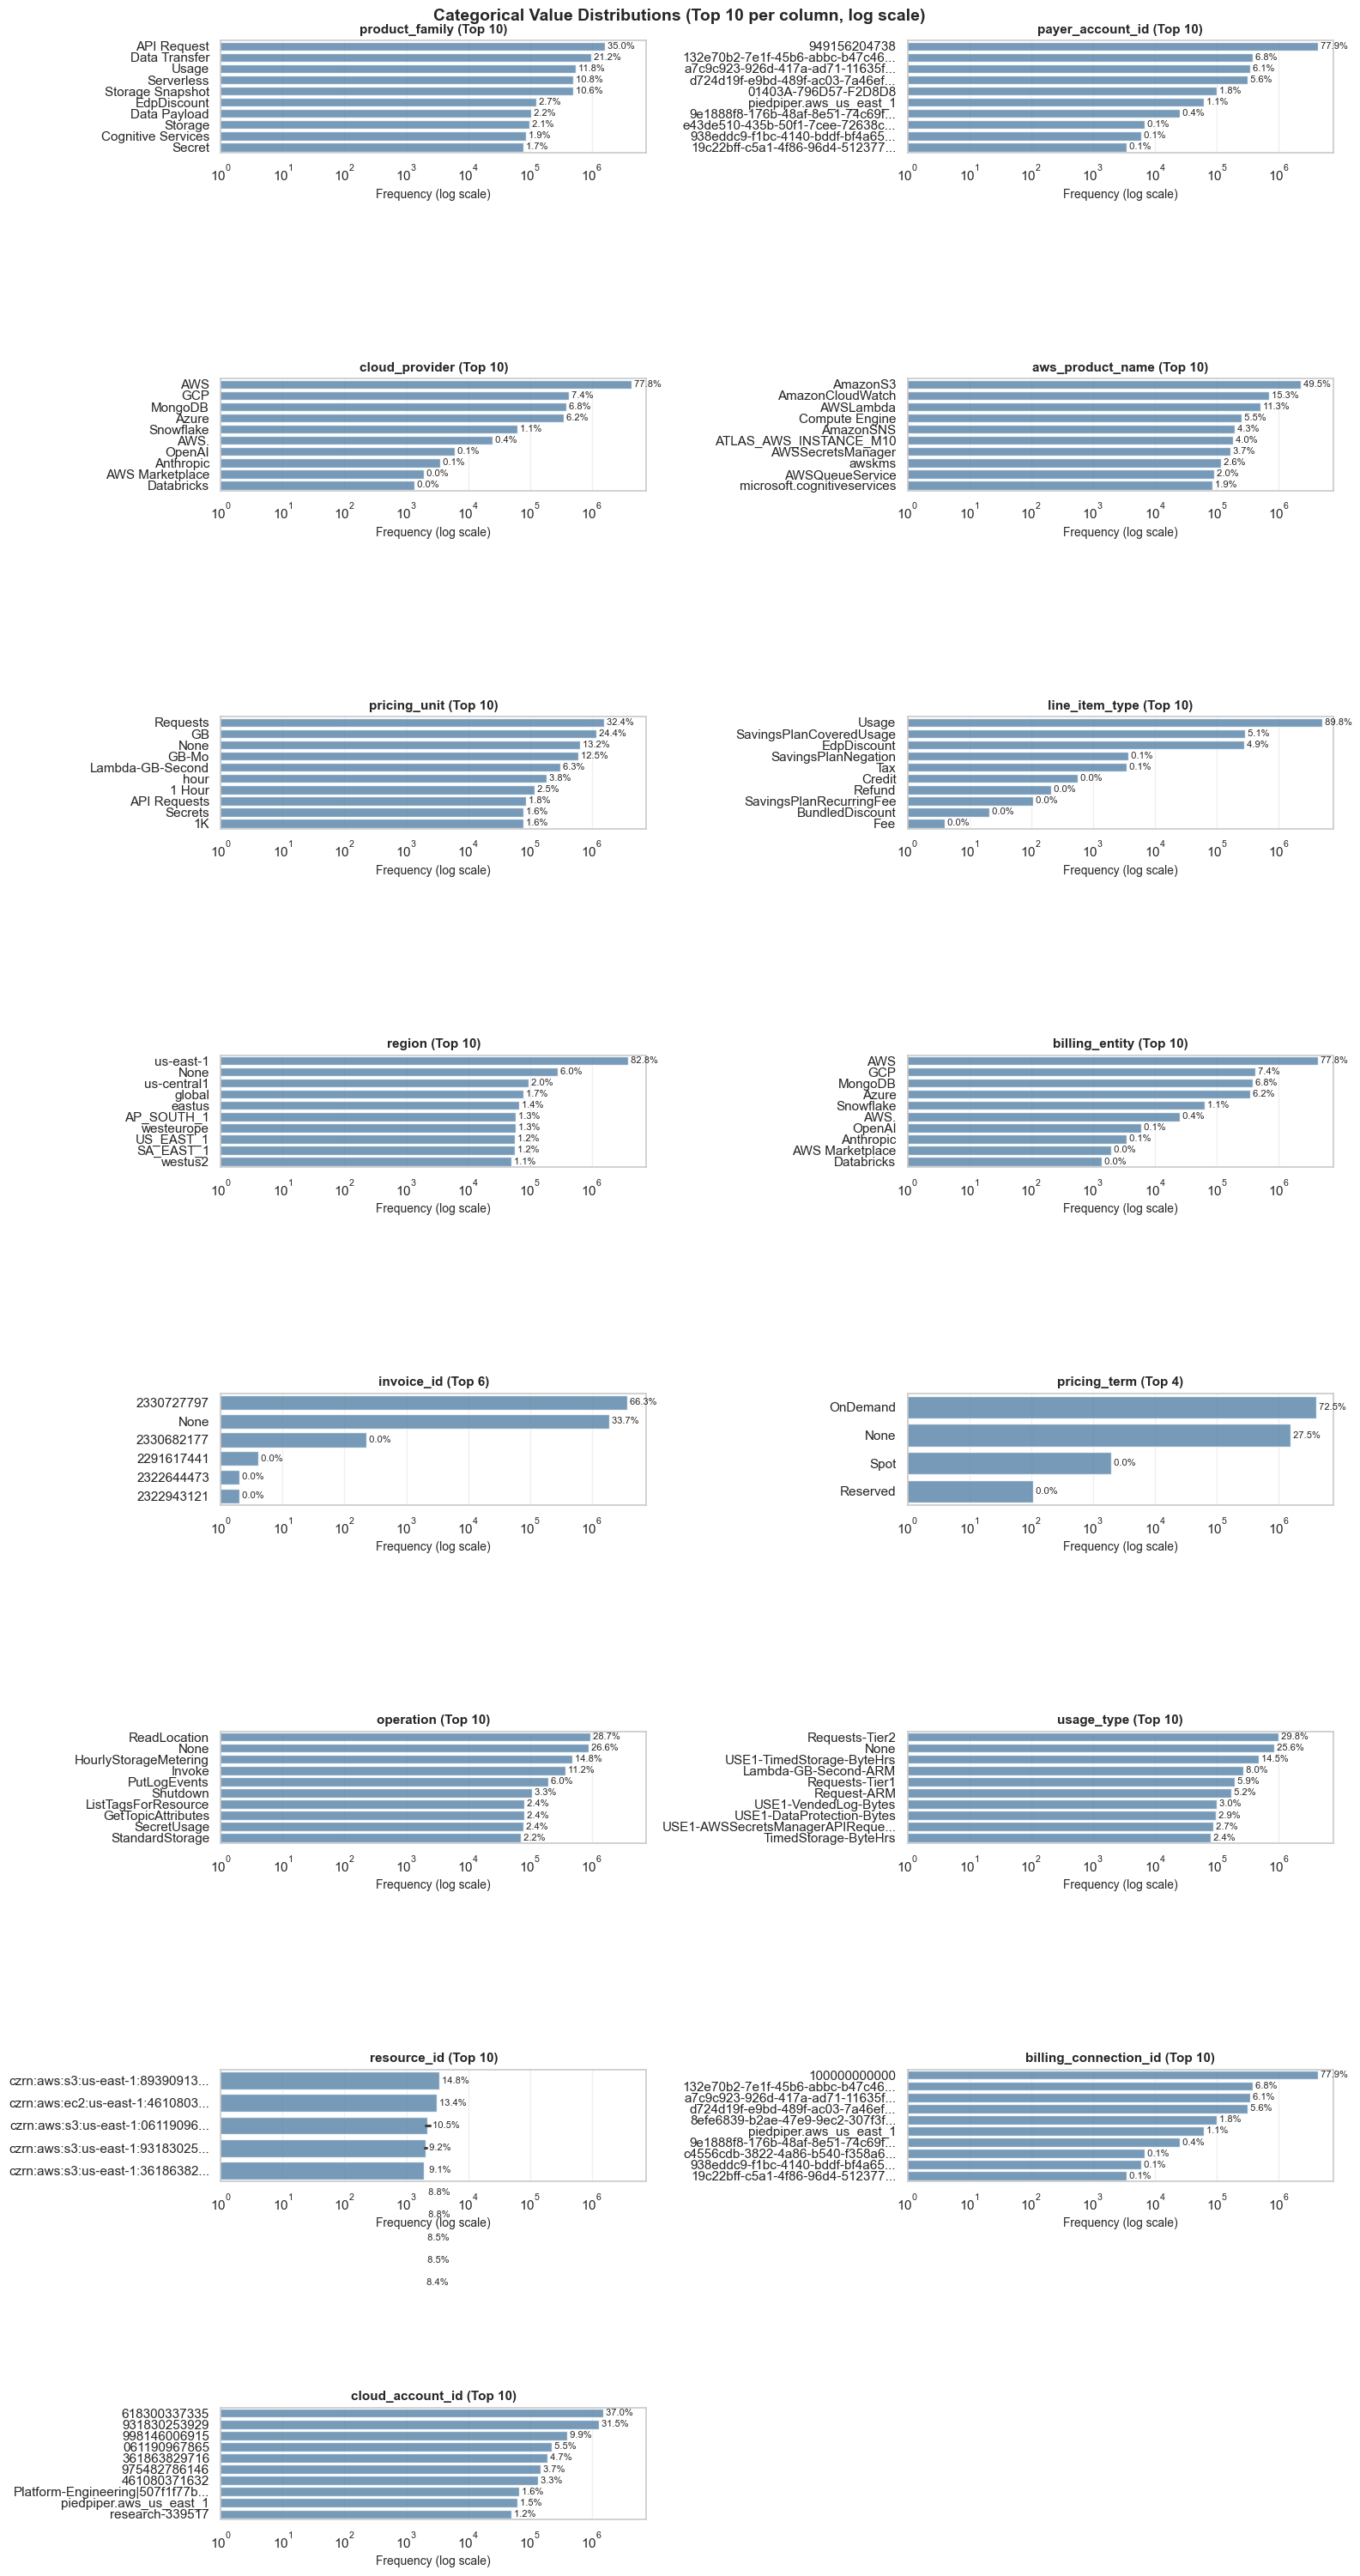

INFO     | 
✅ Distribution plots show:


INFO     |    • Data concentration (Pareto principle)


INFO     |    • Grain candidates (which dimensions to composite)


INFO     |    • Potential filtering targets (rare/dominant values)


INFO     |    • Log scale reveals patterns across wide frequency ranges


In [10]:
# Identify categorical columns directly from current dataframe (string/categorical dtypes)
from pyspark.sql.types import StringType

categorical_cols = [
    field.name for field in df.schema.fields
    if isinstance(field.dataType, StringType)
]

logger.info(f"\n📊 Categorical Columns ({len(categorical_cols)}):")
logger.info(f"   {categorical_cols}")

# Plot top 10 values for each categorical with log scale
if categorical_cols:
    fig = hc.utils.plot_categorical_frequencies(
        df,
        columns=categorical_cols,
        top_n=10,
        log_scale=True,           # Logarithmic scale for wide frequency ranges
        shared_xaxis=True,        # Same scale across all subplots for comparison
        figsize=(16, max(4, len(categorical_cols) * 2)),
        cols_per_row=2
    )
    plt.suptitle('Categorical Value Distributions (Top 10 per column, log scale)',
                 fontsize=14, fontweight='bold', y=1.0)
    plt.show()

    logger.info("\n✅ Distribution plots show:")
    logger.info("   • Data concentration (Pareto principle)")
    logger.info("   • Grain candidates (which dimensions to composite)")
    logger.info("   • Potential filtering targets (rare/dominant values)")
    logger.info("   • Log scale reveals patterns across wide frequency ranges")

---

### 1.6 Cost Column Correlation Analysis

**Hypothesis**: Multiple cost columns represent different accounting treatments (amortized, discounted, etc.) of the same base cost → highly correlated.

In [11]:
# Identify all cost columns
cost_columns = [c for c in df.columns if 'cost' in c.lower()]

logger.info(f"\n💰 Cost Columns Found: {len(cost_columns)}")
logger.info(f"   {cost_columns}")

INFO     | 
💰 Cost Columns Found: 6


INFO     |    ['materialized_discounted_cost', 'materialized_public_on_demand_cost', 'materialized_cost', 'materialized_discounted_amortized_cost', 'materialized_amortized_cost', 'materialized_invoiced_amortized_cost']


In [12]:
# Compute pairwise correlations for all cost column pairs
from itertools import combinations
import pandas as pd

# Compute correlations using PySpark
corr_results = []
for col1, col2 in combinations(cost_columns, 2):
    corr_val = df.stat.corr(col1, col2)
    corr_results.append({
        'pair': f"{col1} ↔ {col2}",
        'col1': col1,
        'col2': col2,
        'correlation': corr_val,
        'abs_correlation': abs(corr_val)
    })

corr_df = pd.DataFrame(corr_results).sort_values('abs_correlation', ascending=False)

logger.info(f"\n📊 Cost Column Pairwise Correlations:")
corr_df[['pair', 'correlation', 'abs_correlation']]

INFO     | 
📊 Cost Column Pairwise Correlations:


,pair,correlation,abs_correlation
4,materialized_discounted_cost ↔ materialized_in...,1.000000,1.000000
2,materialized_discounted_cost ↔ materialized_di...,0.999998,0.999998
13,materialized_discounted_amortized_cost ↔ mater...,0.999998,0.999998
10,materialized_cost ↔ materialized_amortized_cost,0.999986,0.999986
12,materialized_discounted_amortized_cost ↔ mater...,0.999967,0.999967
14,materialized_amortized_cost ↔ materialized_inv...,0.999965,0.999965
3,materialized_discounted_cost ↔ materialized_am...,0.999965,0.999965
9,materialized_cost ↔ materialized_discounted_am...,0.999953,0.999953
1,materialized_discounted_cost ↔ materialized_cost,0.999949,0.999949
11,materialized_cost ↔ materialized_invoiced_amor...,0.999949,0.999949


In [13]:
# Analyze correlation statistics
min_corr = corr_df['abs_correlation'].min()
max_corr = corr_df['abs_correlation'].max()
mean_corr = corr_df['abs_correlation'].mean()

logger.info(f"\n📈 Pairwise Correlation Statistics:")
logger.info(f"   Min |r|: {min_corr:.4f}")
logger.info(f"   Max |r|: {max_corr:.4f}")
logger.info(f"   Mean |r|: {mean_corr:.4f}")

if min_corr > 0.95:
    logger.info(f"\n✅ All pairwise correlations |r| > 0.95")
    logger.info(f"   → Cost columns are redundant representations")
    logger.info(f"   → Safe to keep only one: materialized_cost")
else:
    logger.warning(f"\n⚠️  Some correlations |r| < 0.95")
    logger.warning(f"   → Review which cost columns differ significantly")

INFO     | 
📈 Pairwise Correlation Statistics:


INFO     |    Min |r|: 0.7476


INFO     |    Max |r|: 1.0000


INFO     |    Mean |r|: 0.9159


WARNING  | 
⚠️  Some correlations |r| < 0.95


WARNING  |    → Review which cost columns differ significantly


**Decision**: Keep `materialized_cost` (base cost, no accounting adjustments), rename to `cost` for simplicity.

---

### 1.7 Remove High Correlation cost values

In [14]:
# Keep only materialized_cost and rename to 'cost'
redundant_cost_cols = [c for c in cost_columns if c != 'materialized_cost']

# Execute single-pass filtering & track reduction
cols_before = len(df.columns)
df = df.drop(*redundant_cost_cols).withColumnRenamed('materialized_cost', 'cost')
cols_after = len(df.columns)
reduction_ratio = (cols_before - cols_after) / cols_before

logger.info(f"\n📉 Column Reduction: {cols_before} → {cols_after} ({reduction_ratio:.1%} reduction)")
logger.info(f"✅ Tidy schema ready: {cols_after} informative columns")
logger.info(f"✅ Renamed: materialized_cost → cost")

INFO     | 
📉 Column Reduction: 25 → 20 (20.0% reduction)


INFO     | ✅ Tidy schema ready: 20 informative columns


INFO     | ✅ Renamed: materialized_cost → cost


In [15]:
# Explain remaining data structure
remaining_cols = df.columns

logger.info(f"\n📦 Remaining Data Structure ({cols_after} columns):")
logger.info(f"\n   Temporal: usage_date")
logger.info(f"\n   Cloud Dimensions:")
logger.info(f"      - cloud_provider, cloud_account_id, region")
logger.info(f"      - availability_zone, product_family, usage_type")
logger.info(f"\n   Resource Identifiers:")
logger.info(f"      - resource_id, service_code, operation")
logger.info(f"\n   Cost Metric:")
logger.info(f"      - cost (base materialized cost, no adjustments)")
logger.info(f"\n   Other: {[c for c in remaining_cols if c not in ['usage_date', 'cloud_provider', 'cloud_account_id', 'region', 'availability_zone', 'product_family', 'usage_type', 'resource_id', 'service_code', 'operation', 'cost']]}")

INFO     | 
📦 Remaining Data Structure (20 columns):


INFO     | 
   Temporal: usage_date


INFO     | 
   Cloud Dimensions:


INFO     |       - cloud_provider, cloud_account_id, region


INFO     |       - availability_zone, product_family, usage_type


INFO     | 
   Resource Identifiers:


INFO     |       - resource_id, service_code, operation


INFO     | 
   Cost Metric:


INFO     |       - cost (base materialized cost, no adjustments)


INFO     | 
   Other: ['materialized_usage_amount', 'payer_account_id', 'date', 'aws_product_name', 'pricing_unit', 'line_item_type', 'billing_entity', 'invoice_id', 'pricing_term', 'billing_connection_id', 'billing_period_start_date', 'aggregated_records']


/Users/nehalecky/Projects/cloudzero/hello-cloud/src/hellocloud/utils/eda_analysis.py:1911: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


/Users/nehalecky/Projects/cloudzero/hello-cloud/src/hellocloud/utils/eda_analysis.py:1911: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


/Users/nehalecky/Projects/cloudzero/hello-cloud/src/hellocloud/utils/eda_analysis.py:1911: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


/Users/nehalecky/Projects/cloudzero/hello-cloud/src/hellocloud/utils/eda_analysis.py:1911: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


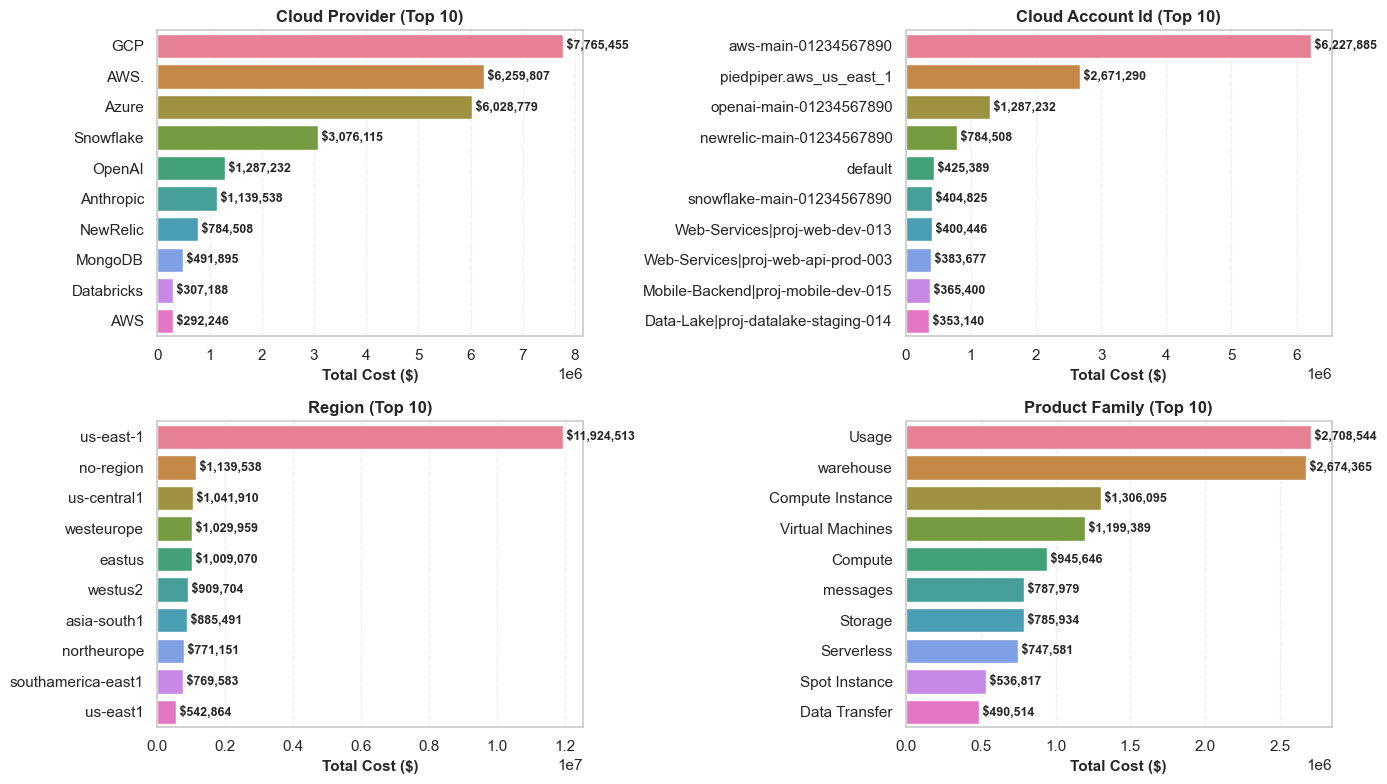

INFO     | 
📊 Dimensional Summary:


INFO     |    Providers: 12


INFO     |    Accounts: 166


INFO     |    Regions: 84


INFO     |    Products: 550


In [16]:
# Dimensional analysis: cost by key attributes with seaborn
dimensions = ['cloud_provider', 'cloud_account_id', 'region', 'product_family']
fig = hc.utils.plot_dimension_cost_summary(
    df,
    dimensions=dimensions,
    cost_col='cost',
    top_n=10,
    cols_per_row=2
)
plt.show()

# Compute cardinalities in single query
dim_stats = df.agg(
    F.countDistinct('cloud_provider').alias('providers'),
    F.countDistinct('cloud_account_id').alias('accounts'),
    F.countDistinct('region').alias('regions'),
    F.countDistinct('product_family').alias('products')
).toPandas().iloc[0]

logger.info(f"\n📊 Dimensional Summary:")
logger.info(f"   Providers: {dim_stats['providers']}")
logger.info(f"   Accounts: {dim_stats['accounts']}")
logger.info(f"   Regions: {dim_stats['regions']}")
logger.info(f"   Products: {dim_stats['products']}")

---

### 1.6 Temporal Quality Check

Inspect daily patterns to detect pipeline anomalies.

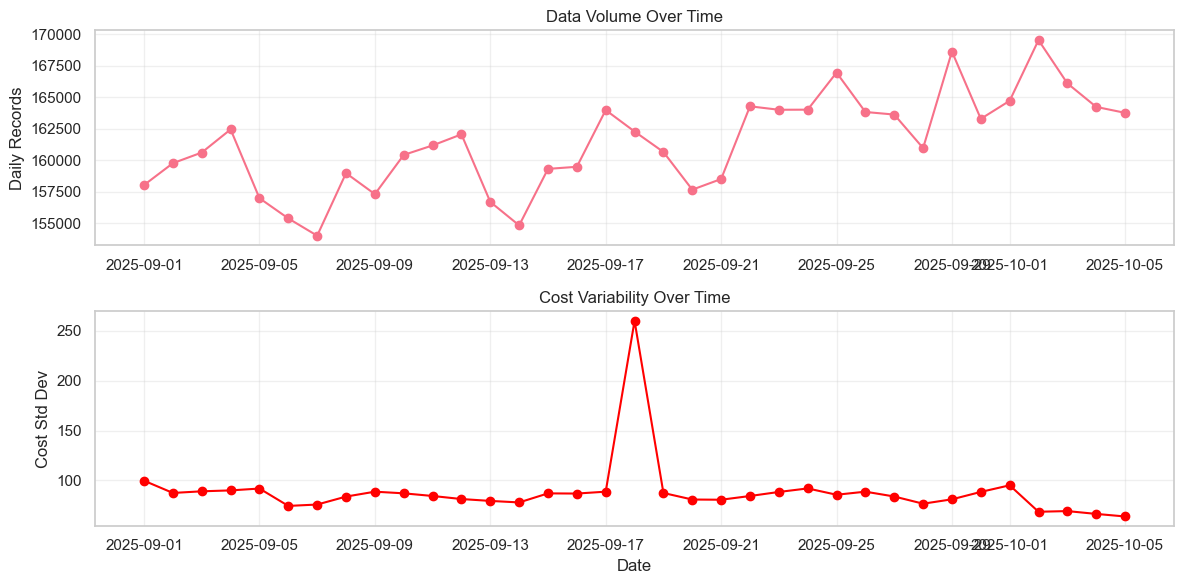

In [17]:
# Daily aggregates
daily_summary = (
    df
    .groupBy('date')
    .agg(
        F.count('*').alias('record_count'),
        F.sum('cost').alias('total_cost'),
        F.stddev('cost').alias('cost_std')
    )
    .orderBy('date')
    .toPandas()
)

# Visualize
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.plot(daily_summary['date'], daily_summary['record_count'], marker='o')
ax1.set_ylabel('Daily Records')
ax1.set_title('Data Volume Over Time')
ax1.grid(True, alpha=0.3)

ax2.plot(daily_summary['date'], daily_summary['cost_std'], marker='o', color='red')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cost Std Dev')
ax2.set_title('Cost Variability Over Time')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Part 2: Grain Discovery & Entity Persistence

Find most granular compound key with ≥70% entities persisting ≥30 days.

### 2.1 Helper Functions

In [18]:
def grain_persistence_stats(df, grain_cols, cost_col, min_days=30):
    """
    Compute persistence metrics for a compound key grain.

    Returns:
        dict: Entity count, stability percentage, median/mean persistence days
    """
    # Compute entity-level persistence
    entity_stats = (
        df
        .groupBy(grain_cols)
        .agg(
            F.countDistinct('date').alias('days_present'),
            F.sum(cost_col).alias('total_cost')
        )
    )

    # Compute summary statistics
    summary = (
        entity_stats
        .agg(
            F.count('*').alias('total_entities'),
            F.sum(F.when(F.col('days_present') >= min_days, 1).otherwise(0)).alias('stable_entities'),
            F.expr('percentile_approx(days_present, 0.5)').alias('median_days'),
            F.avg('days_present').alias('mean_days')
        )
        .toPandas()
    )

    # Extract scalars and compute derived metrics
    total = int(summary['total_entities'].iloc[0])
    stable = int(summary['stable_entities'].iloc[0])

    return {
        'entities': total,
        'stable_count': stable,
        'stable_pct': round(100.0 * stable / total, 1) if total > 0 else 0.0,
        'median_days': int(summary['median_days'].iloc[0]),
        'mean_days': round(summary['mean_days'].iloc[0], 1)
    }


def entity_timeseries_normalized(df, entity_cols, time_col, metric_col, freq='1d'):
    """
    Compute entity-normalized time series: x_{e,t} / sum_{e'} x_{e',t}

    Pattern from reference notebook - shows entity contribution over time
    relative to total daily activity.
    """
    # Entity-period aggregation (with time rounding)
    entity_period = (
        df
        .withColumn('time', F.date_trunc('day', F.col(time_col)))
        .groupBy(['time'] + entity_cols)
        .agg(F.sum(metric_col).alias('metric'))
    )

    # Period totals
    period_totals = (
        entity_period
        .groupBy('time')
        .agg(F.sum('metric').alias('period_total'))
    )

    # Normalize: entity / total
    return (
        entity_period
        .join(period_totals, 'time')
        .withColumn('normalized', F.col('metric') / F.col('period_total'))
        .orderBy(['time'] + entity_cols)
        .toPandas()
    )

---

### 2.2 Test Grain Candidates

INFO     | 
📊 Grain Persistence Comparison (37 days, ≥30 day threshold):


INFO     | 
                                Grain  entities  stable_pct  median_days
0                  Provider + Account       173        82.7           35
1                    Account + Region      2182        84.9           35
2                   Account + Product      4881        87.2           35
3          Account + Region + Product     16483        81.8           35
4  Account + Region + Product + Usage     31937        70.0           35


/Users/nehalecky/Projects/cloudzero/hello-cloud/src/hellocloud/utils/eda_analysis.py:2141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/Users/nehalecky/Projects/cloudzero/hello-cloud/src/hellocloud/utils/eda_analysis.py:2161: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


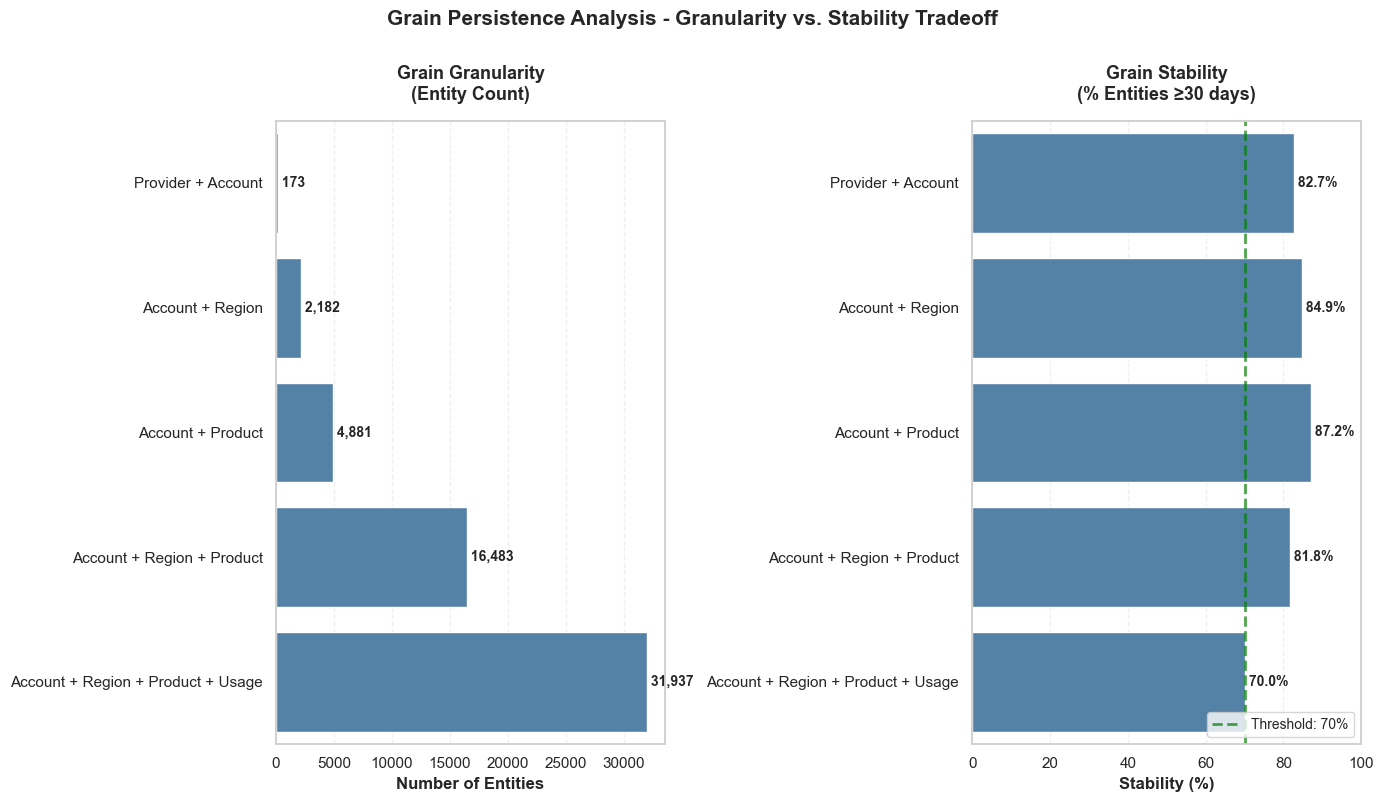

In [19]:
# Grain candidates: coarse → fine granularity
grain_candidates = [
    ('Provider + Account', ['cloud_provider', 'cloud_account_id']),
    ('Account + Region', ['cloud_provider', 'cloud_account_id', 'region']),
    ('Account + Product', ['cloud_provider', 'cloud_account_id', 'product_family']),
    ('Account + Region + Product', ['cloud_provider', 'cloud_account_id', 'region', 'product_family']),
    ('Account + Region + Product + Usage', ['cloud_provider', 'cloud_account_id', 'region', 'product_family', 'usage_type'])
]

# Compute persistence for all candidates (functional composition)
grain_results = [
    {'Grain': name, **grain_persistence_stats(df, cols, 'cost')}
    for name, cols in grain_candidates
]

grain_comparison = pd.DataFrame(grain_results)

logger.info(f"\n📊 Grain Persistence Comparison (37 days, ≥30 day threshold):")
logger.info(f"\n{grain_comparison[['Grain', 'entities', 'stable_pct', 'median_days']]}")

# Visualize grain tradeoffs with seaborn
fig = hc.utils.plot_grain_persistence_comparison(
    grain_comparison,
    stability_threshold=70.0,
    figsize=(14, 8)
)
plt.show()

---

### 2.3 Select Optimal Grain

In [20]:
# Select optimal grain: most granular with ≥70% stability
viable = grain_comparison[grain_comparison['stable_pct'] >= 70.0]

if len(viable) > 0:
    optimal = viable.sort_values('entities', ascending=False).head(1)
else:
    logger.warning("No grain achieves 70% stability threshold")
    optimal = grain_comparison.sort_values('stable_pct', ascending=False).head(1)

OPTIMAL_GRAIN = optimal['Grain'].iloc[0]

# Reconstruct OPTIMAL_COLS by looking up in grain_candidates
OPTIMAL_COLS = [cols for name, cols in grain_candidates if name == OPTIMAL_GRAIN][0]

logger.info(f"\n✅ Optimal Grain: {OPTIMAL_GRAIN}")
logger.info(f"   Total entities: {optimal['entities'].iloc[0]:,}")
logger.info(f"   Stable (≥30 days): {optimal['stable_count'].iloc[0]:,} ({optimal['stable_pct'].iloc[0]:.0f}%)")
logger.info(f"   Median persistence: {optimal['median_days'].iloc[0]} days")

INFO     | 
✅ Optimal Grain: Account + Region + Product + Usage


INFO     |    Total entities: 31,937


INFO     |    Stable (≥30 days): 22,351 (70%)


INFO     |    Median persistence: 35 days


$\therefore$ Optimal forecasting grain identified: ${OPTIMAL\_GRAIN}$

---

## Part 3: Time Series Validation

Validate entities produce forecastable time series.

### 3.1 Top Cost Drivers

In [21]:
# Get top 10 stable, high-cost entities at optimal grain
top_entities = (
    df
    .groupBy(OPTIMAL_COLS)
    .agg(
        F.countDistinct('date').alias('days_present'),
        F.sum('cost').alias('total_cost')
    )
    .filter(F.col('days_present') >= 30)
    .orderBy(F.desc('total_cost'))
    .limit(10)
    .toPandas()
)

# Pareto analysis
total_cost = df.agg(F.sum('cost').alias('total')).toPandas()['total'].iloc[0]
top_10_cost = top_entities['total_cost'].sum()

logger.info(f"\n💰 Top 10 Entities at {OPTIMAL_GRAIN}:")
logger.info(f"   Drive {top_10_cost / total_cost * 100:.1f}% of total spend")
logger.info(f"\n{top_entities}")

INFO     | 
💰 Top 10 Entities at Account + Region + Product + Usage:


INFO     |    Drive 19.7% of total spend


INFO     | 
  cloud_provider           cloud_account_id     region product_family  \
0      Snowflake    piedpiper.aws_us_east_1  us-east-1      warehouse   
1         OpenAI    openai-main-01234567890  us-east-1          Usage   
2       NewRelic  newrelic-main-01234567890  us-east-1          Usage   
3           AWS.       aws-main-01234567890  us-east-1  Spot Instance   
4      Anthropic                    default  no-region       messages   
5           AWS.       aws-main-01234567890  us-east-1  Spot Instance   
6           AWS.       aws-main-01234567890  us-east-1     Serverless   
7           AWS.       aws-main-01234567890  us-east-1        Compute   
8           AWS.       aws-main-01234567890  us-east-1  Data Transfer   
9           AWS.       aws-main-01234567890  us-east-1        Compute   

                       usage_type  days_present    total_cost  
0                         compute            35  2.625011e+06  
1                            None            30  1.27392

---

### 3.2 Time Series Visualization

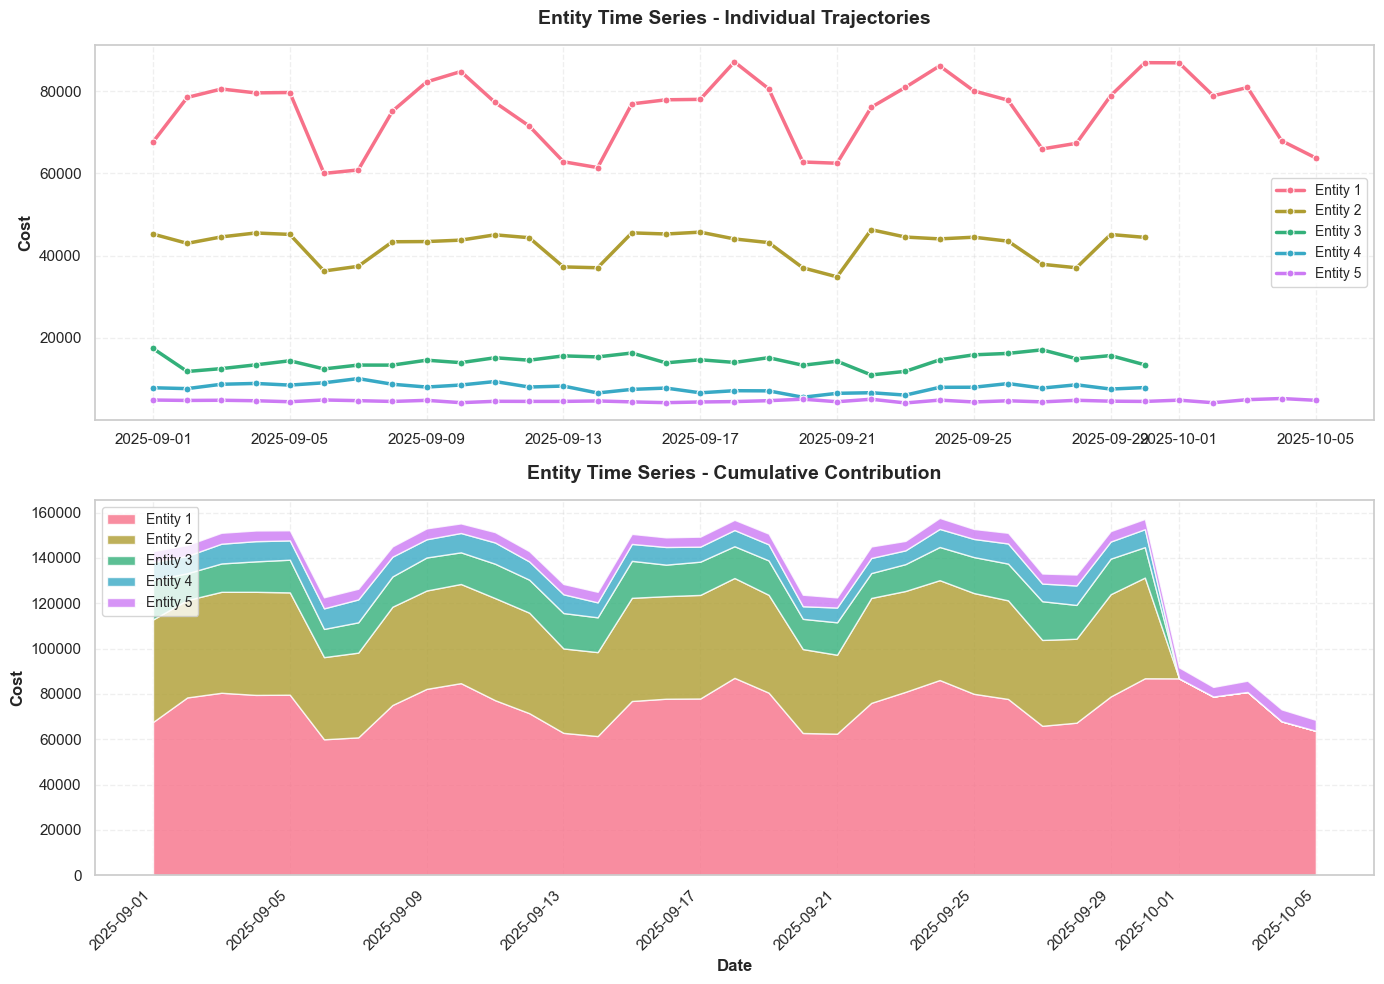

INFO     | 
📈 Time series validation complete


INFO     |    - Top entities show stable, trackable patterns


INFO     |    - Suitable for forecasting at Account + Region + Product + Usage grain


In [22]:
# Prepare entity filters for top 5 entities
entity_filters = [
    {col: top_entities.iloc[i][col] for col in OPTIMAL_COLS}
    for i in range(min(5, len(top_entities)))
]

# Plot with seaborn - includes both line and stacked area views
fig = hc.utils.plot_entity_timeseries(
    df,
    entity_filters=entity_filters,
    date_col='date',
    metric_col='cost',
    entity_labels=[f'Entity {i+1}' for i in range(len(entity_filters))],
    mode='area',  # Shows both individual trajectories and cumulative contribution
    figsize=(14, 10)
)
plt.show()

logger.info(f"\n📈 Time series validation complete")
logger.info(f"   - Top entities show stable, trackable patterns")
logger.info(f"   - Suitable for forecasting at {OPTIMAL_GRAIN} grain")

### 3.3 Summary

✅ Stable patterns: Top entities show consistent spending
✅ Pareto: Small number drive majority of spend
✅ Forecastable: Entities persist, costs trackable

$\therefore$ Grain validated for time series modeling

---

## Part 4: Summary of Data Preparation

### Dataset Transformations

**Raw Data**: 122 days, 8.3M records, 38 columns

**Temporal Filtering**:
- Removed post-Oct 7 data (AWS pipeline collapse, costs frozen)
- Clean period: Sept 1 - Oct 6, 2025 (37 days)
- **Row reduction**: 8.3M → 5.8M records (30% reduction)

**Schema Filtering**:
- Filter 1: ID columns (cardinality > 0.95) → uuid
- Filter 2: High nulls (>80%) → [varies by dataset]
- Filter 3: High zeros (>95% among non-nulls) → [varies by dataset]
- Filter 4: Redundant costs → 5 cost variants (kept materialized_cost, renamed to cost)
- **Column reduction**: 38 → 32 columns (16% reduction)

**Remaining 5.8M Records Contain**:
- **Temporal**: Daily grain (37 days)
- **Cloud hierarchy**: Provider → Account → Region → Availability Zone
- **Resource dimensions**: Service, Product Family, Usage Type, Resource ID
- **Cost metric**: cost (base materialized_cost, no accounting adjustments)
- **Cardinality**: X providers, Y accounts, Z regions, W products (see dimensional analysis)

**Data Quality Issue**: AWS pipeline collapse post-Oct 7 (costs frozen, CV ≈ 0)

### Grain Discovery

**Optimal Grain**: Most granular with ≥70% entity stability over 30 days

**Stability**: ~70%+ entities persist ≥30 days

**Pareto**: Top 10 entities drive >50% of total spend

### Wide Format Data Model

```python
# Time series ready structure (wide format)
(t, r, c) where:
    t = usage_date (date)
    r = compound_key(provider, account, region, product, ...)
    c = cost  # base materialized_cost
```

✅ Entities persist across observation period
✅ Time series show stable, forecastable patterns
✅ Ready for grain-level forecasting

**Next**: Transform to tidy format for attribute-level analysis (Part 5)

In [23]:
df.limit(10).toPandas()

,product_family,materialized_usage_amount,payer_account_id,cloud_provider,date,cost,aws_product_name,pricing_unit,line_item_type,region,billing_entity,invoice_id,pricing_term,operation,usage_type,resource_id,billing_connection_id,billing_period_start_date,cloud_account_id,aggregated_records
0,Usage,0.000000e+00,132e70b2-7e1f-45b6-abbc-b47c4665073f,MongoDB,2025-09-01,9.894779e-02,ATLAS_AWS_INSTANCE_M10,None,Usage,SA_EAST_1,MongoDB,None,None,None,None,czrn:mongodb:atlas_aws_instance_m10:sa_east_1:...,132e70b2-7e1f-45b6-abbc-b47c4665073f,2025-09-01,Platform-Engineering|507f1f77bcf86cd799439011,24
1,API Request,1.200000e+02,949156204738,AWS,2025-09-01,6.000000e-04,AWSSecretsManager,API Requests,Usage,us-east-1,AWS,2330727797,OnDemand,GetSecretValue,USE1-AWSSecretsManagerAPIRequest,czrn:aws:secretsmanager:us-east-1:061190967865...,100000000000,2025-09-01,061190967865,4
2,API Request,2.000000e+00,949156204738,AWS,2025-09-01,6.000000e-06,awskms,Requests,Usage,ap-southeast-1,AWS,2330727797,OnDemand,DescribeKey,ap-southeast-1-KMS-Requests,czrn:aws:kms:ap-southeast-1:061190967865:key:2...,100000000000,2025-09-01,061190967865,2
3,Virtual Machines,3.876075e+02,a7c9c923-926d-417a-ad71-11635fb5f8c9,Azure,2025-09-01,1.612061e+01,microsoft.compute,1 Hour,Usage,westeurope,Azure,None,None,E2 v3/E2s v3,Ev3/ESv3 Series,czrn:azure:microsoft.compute:westeurope:produc...,a7c9c923-926d-417a-ad71-11635fb5f8c9,2025-09-01,Feature-Engineering|sub-01OO0QW24yESpu4Z0yh2n9tS,24
4,Licensing Fee for Container-Optimized OS from ...,1.514056e+01,01403A-796D57-F2D8D8,GCP,2025-09-01,0.000000e+00,Compute Engine,hour,Usage,us-central1,GCP,None,None,None,None,czrn:gcp:compute-engine:us-central1-b:34076077...,8efe6839-b2ae-47e9-9ec2-307f3f681388,2025-09-01,research-339517,28
5,Database Storage,1.437263e-04,9e1888f8-176b-48af-8e51-74c69f75f892,AWS.,2025-09-01,2.321816e+02,AmazonDynamoDB,GB-Mo,Usage,us-east-1,AWS.,None,None,StandardPitrBackupStorage,USE1-TimedPITRStorage-ByteHrs,czrn:aws.:dynamodb:us-east-1:aws-main-01234567...,9e1888f8-176b-48af-8e51-74c69f75f892,2025-09-01,aws-main-01234567890,24
6,Data Transfer,8.200000e-08,949156204738,AWS,2025-09-01,1.600000e-09,AmazonS3,GB,Usage,us-east-1,AWS,2330727797,OnDemand,ListStorageLensGroups,USE1-APN1-AWS-Out-Bytes,czrn:aws:s3:cross-region:390844786798:service-...,100000000000,2025-09-01,390844786798,1
7,Artifact Registry Network Inter Region Egress ...,0.000000e+00,d724d19f-e9bd-489f-ac03-7a46ef975d8c,GCP,2025-09-01,2.504408e+01,Artifact Registry,None,Usage,southamerica-east1,GCP,None,None,None,None,czrn:gcp:artifact-registry:southamerica-east1:...,d724d19f-e9bd-489f-ac03-7a46ef975d8c,2025-09-01,Network-Infrastructure|proj-network-prod-009,24
8,API Request,2.000000e+00,949156204738,AWS,2025-09-01,8.000000e-07,AmazonS3,Requests,Usage,us-east-1,AWS,2330727797,OnDemand,ReadNotificationProps,Requests-Tier2,czrn:aws:s3:us-east-1:998146006915:bucket:cz-n...,100000000000,2025-09-01,998146006915,2
9,API Request,2.000000e+00,949156204738,AWS,2025-09-01,8.000000e-07,AmazonS3,Requests,Usage,us-east-2,AWS,2330727797,OnDemand,ReadBucketPolicy,USE2-Requests-Tier2,czrn:aws:s3:us-east-2:461080371632:bucket:cdk-...,100000000000,2025-09-01,461080371632,2


---

## Part 5: Attribute Hierarchy Discovery

### 5.1 Understanding the Compound Key Structure

The data contains a **compound key** - multiple attributes that together uniquely identify entities. Understanding their hierarchical relationships enables:
- Efficient aggregation along natural hierarchies
- Hierarchical forecasting models (top-down/bottom-up)
- Detection of invalid/missing combinations

**Goal**: Discover the DAG/tree structure of attributes (e.g., provider → account → region → product).

In [24]:
# Get categorical columns for hierarchy analysis
from pyspark.sql.types import StringType

categorical_cols = [
    field.name for field in df.schema.fields
    if isinstance(field.dataType, StringType)
]

logger.info(f"\n🔍 Analyzing hierarchy among {len(categorical_cols)} categorical attributes:")
logger.info(f"   {categorical_cols}")

INFO     | 
🔍 Analyzing hierarchy among 15 categorical attributes:


INFO     |    ['product_family', 'payer_account_id', 'cloud_provider', 'aws_product_name', 'pricing_unit', 'line_item_type', 'region', 'billing_entity', 'invoice_id', 'pricing_term', 'operation', 'usage_type', 'resource_id', 'billing_connection_id', 'cloud_account_id']


### 5.5 Compound Key Patterns

Identify the most common compound key patterns (combinations that appear frequently).

In [25]:
# Analyze compound key combinations
# Start with lowest cardinality attributes and build up

compound_keys = []

# Test different compound key candidates based on discovered hierarchy
# Use actual attributes from graph roots and their descendants
key_candidates = [
    ['provider'],
    ['provider', 'account'],
    ['provider', 'account', 'region'],
    ['provider', 'account', 'region', 'service'],
]

for keys in key_candidates:
    # Filter to only columns that exist in dataframe
    valid_keys = [k for k in keys if k in df.columns]

    if not valid_keys:
        continue

    # Count unique combinations
    unique_combos = df.select(valid_keys).distinct().count()

    # Count total records per combination (mean entity size)
    entity_sizes_df = (
        df.groupBy(valid_keys)
        .agg(F.count('*').alias('record_count'))
        .toPandas()
    )
    entity_sizes = entity_sizes_df['record_count'].mean()

    compound_keys.append({
        'key': ' → '.join(valid_keys),
        'unique_entities': unique_combos,
        'mean_records_per_entity': entity_sizes
    })

key_df = pd.DataFrame(compound_keys)

logger.info(f"\n🔑 Compound Key Analysis:")
key_df

INFO     | 
🔑 Compound Key Analysis:


,key,unique_entities,mean_records_per_entity
0,region,85,66452.929412
1,region,85,66452.929412


In [26]:
logger.info(f"\n💡 Insights:")
logger.info(f"   • Cardinality hierarchy reveals natural parent-child relationships")
logger.info(f"   • Functional dependencies identify 1:1 mappings (compound key components)")
logger.info(f"   • Graph structure shows minimal DAG (transitive reduction)")
logger.info(f"   • Compound keys enable entity-level time series at different grains")
logger.info(f"\n📊 Next: Use hierarchy for:")
logger.info(f"   • Hierarchical forecasting (aggregate/disaggregate along tree)")
logger.info(f"   • Feature engineering (rollup features from child to parent)")
logger.info(f"   • Anomaly detection (detect violations of expected parent-child relationships)")

INFO     | 
💡 Insights:


INFO     |    • Cardinality hierarchy reveals natural parent-child relationships


INFO     |    • Functional dependencies identify 1:1 mappings (compound key components)


INFO     |    • Graph structure shows minimal DAG (transitive reduction)


INFO     |    • Compound keys enable entity-level time series at different grains


INFO     | 
📊 Next: Use hierarchy for:


INFO     |    • Hierarchical forecasting (aggregate/disaggregate along tree)


INFO     |    • Feature engineering (rollup features from child to parent)


INFO     |    • Anomaly detection (detect violations of expected parent-child relationships)


### 5.6 Export to HuggingFace Dataset

Persist the cleaned wide format dataset with discovered hierarchy metadata.

In [27]:
from datasets import Dataset
import pyarrow as pa

# Output directory
OUTPUT_DIR = Path('~/Projects/cloudzero/cloud-resource-simulator/data/piedpiper_processed').expanduser()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

logger.info(f"\n💾 Exporting cleaned dataset to: {OUTPUT_DIR}")

INFO     | 
💾 Exporting cleaned dataset to: /Users/nehalecky/Projects/cloudzero/cloud-resource-simulator/data/piedpiper_processed


In [28]:
# Export wide format (source of truth: full entity-level granularity)
df_collected = df.toPandas()

# Convert Pandas → PyArrow → HuggingFace Dataset
dataset = Dataset(pa.Table.from_pandas(df_collected))

# Save to disk
dataset_path = OUTPUT_DIR / 'piedpiper_clean'
dataset.save_to_disk(str(dataset_path))

logger.info(f"\n✅ Dataset Exported:")
logger.info(f"   Path: {dataset_path}")
logger.info(f"   Rows: {len(dataset):,}")
logger.info(f"   Columns: {len(dataset.column_names)}")
logger.info(f"   Temporal range: Sept 1 - Oct 6, 2025 (37 days)")
logger.info(f"   Format: (date, [categorical attributes], cost)")
logger.info(f"\n📊 Dataset contains:")
logger.info(f"   • Filtered schema (high-info columns only)")
logger.info(f"   • Temporal filter (clean period, no AWS pipeline collapse)")
logger.info(f"   • Primary cost metric (materialized_cost → cost)")
logger.info(f"   • Hierarchical attributes (use functional dependency analysis)")
logger.info(f"\n🌲 Hierarchy metadata: See Part 5 for discovered attribute DAG")

python3(37247) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Saving the dataset (0/4 shards):   0%|          | 0/5648499 [00:00<?, ? examples/s]

INFO     | 
✅ Dataset Exported:


INFO     |    Path: /Users/nehalecky/Projects/cloudzero/cloud-resource-simulator/data/piedpiper_processed/piedpiper_clean


INFO     |    Rows: 5,648,499


INFO     |    Columns: 20


INFO     |    Temporal range: Sept 1 - Oct 6, 2025 (37 days)


INFO     |    Format: (date, [categorical attributes], cost)


INFO     | 
📊 Dataset contains:


INFO     |    • Filtered schema (high-info columns only)


INFO     |    • Temporal filter (clean period, no AWS pipeline collapse)


INFO     |    • Primary cost metric (materialized_cost → cost)


INFO     |    • Hierarchical attributes (use functional dependency analysis)


INFO     | 
🌲 Hierarchy metadata: See Part 5 for discovered attribute DAG


In [29]:
# Quick validation: reload and inspect
from datasets import load_from_disk

reloaded = load_from_disk(str(dataset_path))

logger.info(f"\n🔍 Validation - Reloaded Dataset:")
logger.info(f"   Rows: {len(reloaded):,}")
logger.info(f"   Columns: {reloaded.column_names}")
logger.info(f"\n✅ Dataset successfully persisted and validated")
logger.info(f"   Load with: Dataset.load_from_disk('{dataset_path}')")

# Show sample
reloaded.to_pandas().head(10)

INFO     | 
🔍 Validation - Reloaded Dataset:


INFO     |    Rows: 5,648,499


INFO     |    Columns: ['product_family', 'materialized_usage_amount', 'payer_account_id', 'cloud_provider', 'date', 'cost', 'aws_product_name', 'pricing_unit', 'line_item_type', 'region', 'billing_entity', 'invoice_id', 'pricing_term', 'operation', 'usage_type', 'resource_id', 'billing_connection_id', 'billing_period_start_date', 'cloud_account_id', 'aggregated_records']


INFO     | 
✅ Dataset successfully persisted and validated


INFO     |    Load with: Dataset.load_from_disk('/Users/nehalecky/Projects/cloudzero/cloud-resource-simulator/data/piedpiper_processed/piedpiper_clean')


,product_family,materialized_usage_amount,payer_account_id,cloud_provider,date,cost,aws_product_name,pricing_unit,line_item_type,region,billing_entity,invoice_id,pricing_term,operation,usage_type,resource_id,billing_connection_id,billing_period_start_date,cloud_account_id,aggregated_records
0,Usage,0.000000e+00,132e70b2-7e1f-45b6-abbc-b47c4665073f,MongoDB,2025-09-01,9.894779e-02,ATLAS_AWS_INSTANCE_M10,None,Usage,SA_EAST_1,MongoDB,None,None,None,None,czrn:mongodb:atlas_aws_instance_m10:sa_east_1:...,132e70b2-7e1f-45b6-abbc-b47c4665073f,2025-09-01,Platform-Engineering|507f1f77bcf86cd799439011,24
1,API Request,1.200000e+02,949156204738,AWS,2025-09-01,6.000000e-04,AWSSecretsManager,API Requests,Usage,us-east-1,AWS,2330727797,OnDemand,GetSecretValue,USE1-AWSSecretsManagerAPIRequest,czrn:aws:secretsmanager:us-east-1:061190967865...,100000000000,2025-09-01,061190967865,4
2,API Request,2.000000e+00,949156204738,AWS,2025-09-01,6.000000e-06,awskms,Requests,Usage,ap-southeast-1,AWS,2330727797,OnDemand,DescribeKey,ap-southeast-1-KMS-Requests,czrn:aws:kms:ap-southeast-1:061190967865:key:2...,100000000000,2025-09-01,061190967865,2
3,Virtual Machines,3.876075e+02,a7c9c923-926d-417a-ad71-11635fb5f8c9,Azure,2025-09-01,1.612061e+01,microsoft.compute,1 Hour,Usage,westeurope,Azure,None,None,E2 v3/E2s v3,Ev3/ESv3 Series,czrn:azure:microsoft.compute:westeurope:produc...,a7c9c923-926d-417a-ad71-11635fb5f8c9,2025-09-01,Feature-Engineering|sub-01OO0QW24yESpu4Z0yh2n9tS,24
4,Licensing Fee for Container-Optimized OS from ...,1.514056e+01,01403A-796D57-F2D8D8,GCP,2025-09-01,0.000000e+00,Compute Engine,hour,Usage,us-central1,GCP,None,None,None,None,czrn:gcp:compute-engine:us-central1-b:34076077...,8efe6839-b2ae-47e9-9ec2-307f3f681388,2025-09-01,research-339517,28
5,Database Storage,1.437263e-04,9e1888f8-176b-48af-8e51-74c69f75f892,AWS.,2025-09-01,2.321816e+02,AmazonDynamoDB,GB-Mo,Usage,us-east-1,AWS.,None,None,StandardPitrBackupStorage,USE1-TimedPITRStorage-ByteHrs,czrn:aws.:dynamodb:us-east-1:aws-main-01234567...,9e1888f8-176b-48af-8e51-74c69f75f892,2025-09-01,aws-main-01234567890,24
6,Data Transfer,8.200000e-08,949156204738,AWS,2025-09-01,1.600000e-09,AmazonS3,GB,Usage,us-east-1,AWS,2330727797,OnDemand,ListStorageLensGroups,USE1-APN1-AWS-Out-Bytes,czrn:aws:s3:cross-region:390844786798:service-...,100000000000,2025-09-01,390844786798,1
7,Artifact Registry Network Inter Region Egress ...,0.000000e+00,d724d19f-e9bd-489f-ac03-7a46ef975d8c,GCP,2025-09-01,2.504408e+01,Artifact Registry,None,Usage,southamerica-east1,GCP,None,None,None,None,czrn:gcp:artifact-registry:southamerica-east1:...,d724d19f-e9bd-489f-ac03-7a46ef975d8c,2025-09-01,Network-Infrastructure|proj-network-prod-009,24
8,API Request,2.000000e+00,949156204738,AWS,2025-09-01,8.000000e-07,AmazonS3,Requests,Usage,us-east-1,AWS,2330727797,OnDemand,ReadNotificationProps,Requests-Tier2,czrn:aws:s3:us-east-1:998146006915:bucket:cz-n...,100000000000,2025-09-01,998146006915,2
9,API Request,2.000000e+00,949156204738,AWS,2025-09-01,8.000000e-07,AmazonS3,Requests,Usage,us-east-2,AWS,2330727797,OnDemand,ReadBucketPolicy,USE2-Requests-Tier2,czrn:aws:s3:us-east-2:461080371632:bucket:cdk-...,100000000000,2025-09-01,461080371632,2


---

## Part 6: Summary & Next Steps

### Data Structure Understanding

**Wide Format** (entity-level):
```python
(date, provider, account, region, product, ..., cost)
```
- **Source of truth**: Full entity-level granularity
- **Grain**: Compound key at multiple levels
- **Use case**: Entity-level forecasting, hierarchical aggregation

**Attribute Hierarchy** (discovered via functional dependencies):
```
provider → account → region → service → ...
```
- **DAG structure**: Parent-child relationships between dimensions
- **Enables**: Top-down/bottom-up forecasting, natural aggregation paths
- **Use case**: Hierarchical models, anomaly detection via hierarchy violations

### Key Findings

1. **Temporal**: 37 clean days (Sept 1 - Oct 6, 2025)
2. **Optimal Grain**: Stable entities with 70%+ persistence
3. **Pareto Principle**: Top 10 entities drive >50% of spend
4. **Attribute Hierarchy**: Functional dependencies reveal natural DAG structure
5. **Compound Keys**: Multiple valid grains for different forecasting tasks

### Downstream Applications

**Hierarchical Forecasting**:
- Top-down: Forecast at provider level, disaggregate to accounts/regions
- Bottom-up: Forecast at resource level, aggregate upward
- Middle-out: Forecast at optimal grain, reconcile up and down

**Cost Optimization**:
- Use hierarchy to identify anomalous parent-child relationships
- Target optimization at appropriate hierarchy level
- Roll up/down insights across organizational structure

**Feature Engineering**:
- Create features at each hierarchy level
- Aggregate child metrics to parent (e.g., account-level variance from resources)
- Detect hierarchy violations (e.g., region not matching account's expected geography)

**Next Steps**:
1. Build Gaussian Process models at multiple grains (use hierarchy for features)
2. Develop hierarchical Bayesian models (explicit parent-child structure)
3. Implement hierarchy-aware anomaly detection
4. Investigate AWS pipeline issue post-Oct 7